# Trabajo Práctico Final - Procesamiento del Lenguaje Natural
## ***Sistema RAG con Agente Autónomo para Consultas sobre Electrodomésticos***

**Año:** 2025  
**Materia:** Procesamiento del Lenguaje Natural  
**Integrantes:** PORCELLI, Fabricio - P-5340/6

Fecha: 14/12/2025

## Objetivo

Desarrollar un asistente virtual especializado en información de una empresa de
electrodomésticos que responde preguntas sobre los productos y los usuarios.

## Dependencias y librerias

Imports integrados en colab

In [1]:
import os, json, re, time, shutil, pickle, sqlite3
from typing import List, Dict
import gdown, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive, userdata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sentence_transformers import SentenceTransformer, CrossEncoder

Instalación de dependencias necesarias

In [2]:
!pip install -q chromadb sentence-transformers groq neo4j rank-bm25 \
  sqlalchemy "langchain==0.1.20" langchain-community langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 13.5 MB/s eta 0:

Import de dependencias instaladas

In [3]:
import chromadb
from rank_bm25 import BM25Okapi
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from groq import Groq

## Configuración

Los datasets y bases de datos generadas se persisten en google drive

In [4]:
drive.mount('/content/drive')

# Rutas
DB_PATH = "/content/chroma_db"
BACKUP_VECTORIAL = "/content/drive/MyDrive/chroma_db.tar.gz"
BACKUP_TABULAR = "/content/drive/MyDrive/tabular_db.pkl"
BACKUP_GRAFO = "/content/drive/MyDrive/graph_db.pkl"

# Descargar datos
url = "https://drive.google.com/uc?id=1HRP-tddPZzCS8fQl0-M0GjZdX0NkRBX_"
gdown.download(url, "fuentes.zip", quiet=False)
with zipfile.ZipFile("fuentes.zip") as z:
    z.extractall("fuentes_de_informacion")

Mounted at /content/drive


Downloading...
From: https://drive.google.com/uc?id=1HRP-tddPZzCS8fQl0-M0GjZdX0NkRBX_
To: /content/fuentes.zip
100%|██████████| 3.18M/3.18M [00:00<00:00, 94.3MB/s]


Se configura el LLM a utilizar, verifica que la api key esté cargada correctamente

In [5]:
# Configurar API
try:
    GROQ_KEY = userdata.get('GROQ_API_KEY')
    client_groq = Groq(api_key=GROQ_KEY)
    print("✓ Groq configurado")
except:
    print("⚠ Configure GROQ_API_KEY")
    client_groq = None

✓ Groq configurado


Se eligen los modelos de embedding y rernk a utilizar

In [6]:
# Modelos
embedding_model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')
rerank_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

# Bases de datos

*JUSTIFICACIÓN DE FUENTES DE DATOS*
```
1. BASE VECTORIAL (ChromaDB + embeddings español):
   - Contenido: Manuales técnicos (.md), FAQs (.json), Reseñas (.txt)
   - Razón: Información textual no estructurada que requiere búsqueda semántica
   - Casos de uso: "¿Cómo usar?", "¿Qué opinan?", "¿Qué voltaje?"
   
2. BASE TABULAR (Pandas DataFrames):
   - Contenido: productos.csv, ventas_historicas.csv, inventario_sucursales.csv,
                tickets_soporte.csv, devoluciones.csv, vendedores.csv
   - Razón: Datos estructurados que requieren filtros precisos y agregaciones
   - Casos de uso: "Productos <$200", "Stock disponible", "Ventas del mes"
   
3. BASE DE GRAFOS (Neo4j simulado con Cypher):
   - Contenido: Relaciones producto-categoría, vendedor-producto, producto-sucursal
   - Razón: Conexiones entre entidades que requieren consultas relacionales
   - Casos de uso: "¿Qué vendió X?", "Productos de categoría Y"
```

## Base de datos Vectorial

Crea la base de datos vectorial, primero verifica que no pueda ser restaurada de una ejecución anterior

In [7]:
print("\n=== PUNTO 1.2: BASE VECTORIAL ===")

# Restaurar o crear
if os.path.exists(BACKUP_VECTORIAL):
    !rm -rf {DB_PATH}
    !tar -xzf {BACKUP_VECTORIAL} -C /content
    print("✓ BD vectorial restaurada")

client = chromadb.PersistentClient(path=DB_PATH)
col_manuales = client.get_or_create_collection("manuales")
col_faqs = client.get_or_create_collection("faqs")
col_resenas = client.get_or_create_collection("resenas")

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50,
    separators=["\n## ", "\n\n", "\n", ". "]
)


=== PUNTO 1.2: BASE VECTORIAL ===
✓ BD vectorial restaurada


Función para cargar en la base de datos vectorial, los distintos tipos de datos:
```
- Manuales
- FAQs
- Reseñas
```
Y luego crea un backup

In [8]:
def cargar_vectorial():
    """Carga manuales, FAQs y reseñas"""
    # Manuales
    docs, metas, ids = [], [], []
    for f in os.listdir("fuentes_de_informacion/manuales_productos"):
        if not f.endswith('.md'): continue
        id_prod = f.split('_')[1]
        with open(f"fuentes_de_informacion/manuales_productos/{f}") as file:
            chunks = text_splitter.split_text(file.read())
        for i, chunk in enumerate(chunks):
            docs.append(chunk)
            metas.append({"tipo": "manual", "id_producto": id_prod})
            ids.append(f"{id_prod}_c{i}")
    embs = embedding_model.encode(docs).tolist()
    col_manuales.add(embeddings=embs, documents=docs, metadatas=metas, ids=ids)
    print(f"  ✓ {len(docs)} chunks manuales")

    # FAQs
    with open("fuentes_de_informacion/faqs.json") as f:
        faqs = json.load(f)
    docs = [f"Q: {x['pregunta']}\nA: {x['respuesta']}" for x in faqs]
    metas = [{"tipo": "faq", "id_producto": x['id_producto']} for x in faqs]
    ids = [x['id_faq'] for x in faqs]
    embs = embedding_model.encode(docs).tolist()
    col_faqs.add(embeddings=embs, documents=docs, metadatas=metas, ids=ids)
    print(f"  ✓ {len(faqs)} FAQs")

    # Reseñas
    docs, metas, ids = [], [], []
    for f in os.listdir("fuentes_de_informacion/resenas_usuarios"):
        if not f.endswith('.txt'): continue
        with open(f"fuentes_de_informacion/resenas_usuarios/{f}") as file:
            texto = file.read()
        id_r = f.replace('resena_', '').replace('.txt', '')
        docs.append(texto)
        metas.append({"tipo": "resena"})
        ids.append(id_r)
    embs = embedding_model.encode(docs).tolist()
    col_resenas.add(embeddings=embs, documents=docs, metadatas=metas, ids=ids)
    print(f"  ✓ {len(docs)} reseñas")

    # Backup
    time.sleep(3)
    shutil.make_archive('/content/chroma_db', 'gztar', '/content', 'chroma_db')
    !mv /content/chroma_db.tar.gz {BACKUP_VECTORIAL}
    print("  ✓ Backup guardado")

Función para búsqueda semántica simple en la base de datos vectorial

In [9]:
def buscar_vectorial(query, tipo=None, k=5):
    """Búsqueda semántica simple"""
    emb = embedding_model.encode([query])[0].tolist()
    cols = {"manual": col_manuales, "faq": col_faqs, "resena": col_resenas}
    if tipo: cols = {tipo: cols[tipo]}

    res = []
    for nombre, col in cols.items():
        r = col.query(query_embeddings=[emb], n_results=k)
        for i in range(len(r['ids'][0])):
            res.append({
                "fuente": nombre,
                "texto": r['documents'][0][i],
                "metadata": r['metadatas'][0][i],
                "distancia": r['distances'][0][i]
            })
    res.sort(key=lambda x: x['distancia'])
    return res[:k]

Verificación de la base de datos vectorial

In [10]:
if col_manuales.count() == 0:
    cargar_vectorial()
else:
    print(f"✓ BD cargada: {col_manuales.count()} manuales, {col_faqs.count()} FAQs, {col_resenas.count()} reseñas")

✓ BD cargada: 1072 manuales, 3000 FAQs, 5015 reseñas


## Base de datos Tabular

In [11]:
print("\n=== PUNTO 1.3: BASE TABULAR ===")

if os.path.exists(BACKUP_TABULAR):
    with open(BACKUP_TABULAR, 'rb') as f:
        dfs = pickle.load(f)
    print("✓ BD tabular restaurada")
else:
    dfs = {
        'productos': pd.read_csv("fuentes_de_informacion/productos.csv"),
        'ventas_historicas': pd.read_csv("fuentes_de_informacion/ventas_historicas.csv"),
        'inventario_sucursales': pd.read_csv("fuentes_de_informacion/inventario_sucursales.csv"),
        'vendedores': pd.read_csv("fuentes_de_informacion/vendedores.csv"),
        'tickets_soporte': pd.read_csv("fuentes_de_informacion/tickets_soporte.csv"),
        'devoluciones': pd.read_csv("fuentes_de_informacion/devoluciones.csv")
    }
    with open(BACKUP_TABULAR, 'wb') as f:
        pickle.dump(dfs, f)
    print("✓ CSVs cargados y guardados")

# Metadata simplificada
metadata = {nombre: {
    "columnas": list(df.columns),
    "filas": len(df)
} for nombre, df in dfs.items()}


=== PUNTO 1.3: BASE TABULAR ===
✓ BD tabular restaurada


Función de busqueda tabular generando queries Pandas por el LLM elegido de groq

In [12]:
def buscar_tabular(query, tabla='productos', limite=10):
    """Búsqueda con filtros generados por LLM"""
    if tabla not in dfs:
        return pd.DataFrame()

    if not client_groq:
        return dfs[tabla].head(limite)

    # Metadata detallada
    cols_info = ", ".join(metadata[tabla]['columnas'])

    prompt= f"""Eres experto en Pandas. Genera código para filtrar la tabla {tabla}.

COLUMNAS DISPONIBLES: {cols_info}

CONSULTA USUARIO: "{query}"

REGLAS CRÍTICAS:
1. Usa SOLO 'df' como variable del DataFrame
2. NO uses comillas tipográficas (' '), usa comillas rectas (' o ")
3. Para filtros de texto usa: df['columna'].str.contains('texto', case=False, na=False)
4. Para filtros numéricos usa: df[df['columna'] < valor]
5. Para múltiples condiciones usa & o |
6. Retorna SOLO el código, sin explicaciones ni markdown

EJEMPLOS:
Query: "licuadoras de menos de 200"
Código: df[(df['nombre'].str.contains('licuadora', case=False, na=False)) & (df['precio_usd'] < 200)]

Query: "productos baratos"
Código: df[df['precio_usd'] < 100]

Query: "productos de cocina"
Código: df[df['categoria'].str.contains('cocina', case=False, na=False)]

Genera el código para: "{query}"
"""

    try:
        resp = client_groq.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=300, temperature=0
        )
        codigo = resp.choices[0].message.content.strip()

        # Limpiar markdown
        if "```python" in codigo:
            codigo = codigo.split("```python")[1].split("```")[0].strip()
        elif "```" in codigo:
            codigo = codigo.split("```")[1].split("```")[0].strip()

        # Reemplazar comillas tipográficas por rectas
        codigo = codigo.replace("'", "'").replace("'", "'").replace(""", '"').replace(""", '"')

        print(f"🤖 Código generado: {codigo}")

        df = dfs[tabla]
        resultado = eval(codigo)

        if isinstance(resultado, pd.Series):
            resultado = df[resultado]

        return resultado.head(limite)

    except Exception as e:
        print(f"Error: {e}")
        # Fallback: búsqueda simple por keywords
        df = dfs[tabla]
        query_lower = query.lower()

        # Intentar filtrar por nombre si existe
        if 'nombre' in df.columns:
            palabras = query_lower.split()
            mask = pd.Series([False] * len(df))
            for palabra in palabras:
                if len(palabra) > 3:  # Ignorar palabras cortas
                    mask |= df['nombre'].str.contains(palabra, case=False, na=False)
            if mask.any():
                resultado = df[mask]

                # Filtrar por precio si se menciona
                if 'precio' in query_lower and 'precio_usd' in df.columns:
                    import re
                    nums = re.findall(r'\d+', query)
                    if nums:
                        precio_max = int(nums[0])
                        resultado = resultado[resultado['precio_usd'] < precio_max]

                return resultado.head(limite)

        return df.head(limite)

## Base de datos de Grafos

Clase base de datos de grafo

In [13]:
print("\n=== PUNTO 1.4: BASE DE GRAFOS ===")

class GrafoDB:
    def __init__(self):
        self.nodos = {}
        self.relaciones = []

    def crear_nodo(self, tipo, id_nodo, props):
        if tipo not in self.nodos:
            self.nodos[tipo] = {}
        self.nodos[tipo][id_nodo] = props

    def crear_relacion(self, n1, rel, n2, props=None):
        self.relaciones.append((n1, rel, n2, props or {}))

    def query(self, texto, limite=10):
        res = []
        texto_lower = texto.lower()

        # Extraer ID específico si existe
        import re
        id_match = re.search(r'(V\d+|P\d+)', texto, re.IGNORECASE)
        id_filtro = id_match.group(1).upper() if id_match else None

        for n1, rel, n2, props in self.relaciones:
            # Filtro por ID si se especifica
            if id_filtro:
                if id_filtro not in [n1, n2]:
                    continue

            if rel == "VENDIO" and ("vendió" in texto_lower or "vendedor" in texto_lower or "venta" in texto_lower):
                res.append({"vendedor": n1, "producto": n2, "props": props})
            elif rel == "PERTENECE_A":
                # Siempre agregar relaciones de categoría si se menciona el producto o categoría
                if id_filtro and n1 == id_filtro:
                    res.append({"producto": n1, "categoria": n2})
                elif "categoría" in texto_lower or "categoria" in texto_lower or "pertenece" in texto_lower:
                    res.append({"producto": n1, "categoria": n2})
            elif rel == "EN_SUCURSAL" and "sucursal" in texto_lower:
                res.append({"producto": n1, "sucursal": n2, "stock": props.get("stock")})

        return res[:limite]

    def guardar(self, ruta):
        with open(ruta, 'wb') as f:
            pickle.dump({'nodos': self.nodos, 'relaciones': self.relaciones}, f)

    def cargar(self, ruta):
        with open(ruta, 'rb') as f:
            data = pickle.load(f)
            self.nodos, self.relaciones = data['nodos'], data['relaciones']


=== PUNTO 1.4: BASE DE GRAFOS ===


Crea el grafo si no puede restaurarlo del repositorio

In [14]:
grafo = GrafoDB()

if os.path.exists(BACKUP_GRAFO):
    grafo.cargar(BACKUP_GRAFO)
    print(f"✓ Grafo restaurado: {len(grafo.relaciones)} relaciones")
else:
    # Construir grafo
    for _, r in dfs['productos'].iterrows():
        grafo.crear_nodo('Producto', r['id_producto'], {'nombre': r['nombre']})
        grafo.crear_relacion(r['id_producto'], 'PERTENECE_A', r['categoria'])

    for _, r in dfs['ventas_historicas'].head(1000).iterrows():
        grafo.crear_relacion(r['id_vendedor'], 'VENDIO', r['id_producto'], {'total': r['total']})

    for _, r in dfs['inventario_sucursales'].head(1000).iterrows():
        grafo.crear_relacion(r['id_producto'], 'EN_SUCURSAL', r['sucursal'], {'stock': r['stock_sucursal']})

    grafo.guardar(BACKUP_GRAFO)
    print(f"✓ Grafo creado: {len(grafo.relaciones)} relaciones")

✓ Grafo restaurado: 2300 relaciones


Función de busqueda en el grafo

In [15]:
def buscar_grafo(query, limite=10):
    return grafo.query(query, limite)

# Clasificador de Intención Avanzado

Configuración del clasificador

In [16]:
# --- CONFIGURACIÓN ---

# Cargar modelo de embeddings (el mismo que usamos en vectorial)
embedding_model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

# Clases de intención
CLASES = ['vectorial', 'tabular', 'grafo']

Datos sintéticos para el entrenamiento de los clasificadores

In [17]:
# --- GENERAR DATOS SINTÉTICOS ---

datos_entrenamiento = {
    'vectorial': [
        "¿Cómo se reemplaza el vaso según el manual?",
        "Opiniones recientes de compradores sobre este modelo",
        "¿Qué indica el manual sobre la potencia máxima?",
        "Guía rápida para armar la licuadora",
        "¿Cómo ajustar correctamente la tapa?",
        "¿Qué dicen los usuarios sobre el nivel de ruido?",
        "Instrucciones para cambiar el accesorio de amasar",
        "Pasos recomendados para una limpieza profunda",
        "¿Qué cuidados indica el manual para prolongar la vida útil?",
        "Opiniones sobre el rendimiento en preparaciones duras",
        "Testimonios sobre el uso diario del electrodoméstico",
        "¿Cómo funciona el modo de autolimpieza?",
        "Guía del fabricante para evitar daños por uso incorrecto",
        "Reseñas verificadas sobre la durabilidad del motor",
        "¿Qué incluye el paquete según las especificaciones?",
        "Manual de seguridad para evitar accidentes",
        "¿Qué opinan los usuarios sobre la calidad del plástico?",
        "Rendimiento comparado con modelos similares",
        "Guía para calibrar la velocidad inicial",
        "¿Qué piezas pueden mojarse según el manual?",
        "Manual de instalación paso a paso",
        "Comentarios sobre el servicio postventa",
        "¿Cómo activar el modo silencioso según el manual?",
        "¿Qué recomiendan los usuarios mantener lubricado?",
        "Guía para evitar vibraciones excesivas",
        "¿Qué beneficios destacan los compradores frecuentes?",
        "Recomendaciones de uso del fabricante",
        "Manual técnico ampliado del producto",
        "Opiniones sobre la relación precio-calidad",
        "Guía oficial para resolver fallas comunes",
        "¿Qué modos de potencia trae el modelo nuevo?",
        "Comentarios sobre facilidad de limpieza",
        "¿Qué indica el manual cuando el motor se traba?",
        "Testimonios sobre el consumo eléctrico",
        "Guía de ensamblaje rápido",
        "Especificaciones técnicas detalladas del motor",
        "¿Cómo cambiar la cuchilla de acero?",
        "Manual oficial de mantenimiento preventivo",
        "¿Qué opinan los expertos sobre la resistencia?",
        "Guía para evitar desperfectos por mal uso"
    ],
    'tabular': [
        "Productos con precio entre 100 y 200 dólares",
        "Inventario total de la sucursal Rosario",
        "Listado de productos con stock estable",
        "Reporte de ventas de febrero",
        "¿Qué productos aumentaron sus ventas este trimestre?",
        "Tickets abiertos esta semana",
        "Promedio de precio por categoría",
        "Productos ordenados por fecha de ingreso",
        "Stock por proveedor",
        "Resumen de devoluciones del mes pasado",
        "¿Qué productos están por debajo del precio promedio?",
        "Comparación de ventas entre sucursales",
        "Listado de productos sin movimiento",
        "Top 5 productos más vendidos del mes",
        "Historial de ventas por producto",
        "Productos con precios inconsistentes",
        "Tickets cerrados en las últimas 24 horas",
        "¿Qué vendedores superaron la meta mensual?",
        "Inventario de electrodomésticos actualizado",
        "Listado de productos discontinuados recientemente",
        "Stock disponible por marca",
        "Reporte global de devoluciones",
        "Unidades vendidas por categoría",
        "¿Cuántos productos están por encima del stock óptimo?",
        "Ventas por día de la semana",
        "Listado de productos en liquidación",
        "Tickets por prioridad",
        "Productos más buscados según métricas internas",
        "Tabla de precios recientes",
        "Unidades devueltas por falla técnica",
        "Sucursales con mayor volumen de ventas",
        "Estadísticas de ventas por modelo",
        "Listado de productos con margen bajo",
        "¿Qué productos fueron descontinuados este trimestre?",
        "Ranking de vendedores por satisfacción",
        "Productos con incremento de stock reciente",
        "Resumen semanal de ventas",
        "Promedio de devoluciones por sucursal",
        "Unidades vendidas por semana",
        "Productos más consultados del catálogo"
    ],
    'grafo': [
        "¿Qué productos comparten la misma marca que P0042?",
        "Clientes conectados a varias compras de electrodomésticos",
        "Relación entre vendedores y los tickets que gestionaron",
        "Productos vinculados a clientes recurrentes",
        "Relaciones entre categorías principales y secundarias",
        "¿Qué sucursales están relacionadas por envío cruzado?",
        "Vendedores conectados a campañas recientes",
        "Productos recomendados junto con modelos similares",
        "Clientes relacionados por historial de compras",
        "Relación entre proveedores y productos defectuosos",
        "¿Qué productos están asociados a reclamos de garantía?",
        "Clientes conectados por compras de gran valor",
        "Vínculos entre marcas y subcategorías",
        "¿Qué vendedores comparten clientes?",
        "Productos conectados en la misma familia de modelos",
        "Clientes conectados a artículos de cocina",
        "Relación entre tickets y clientes frecuentes",
        "¿Qué productos comparte el mismo proveedor?",
        "Sucursales relacionadas según volumen de ventas",
        "Rutas entre categorías y productos derivados",
        "Productos conectados por compatibilidad técnica",
        "Clientes relacionados con múltiples devoluciones",
        "Vínculos entre clientes y vendedores asignados",
        "¿Qué productos se agrupan por marca y categoría?",
        "Productos relacionados a partir del catálogo extendido",
        "Clientes vinculados a compras recientes",
        "Relaciones entre vendedores y marcas populares",
        "Sucursales con inventarios conectados",
        "Productos conectados por uso habitual",
        "¿Qué marcas tienen relación directa con Cocina?",
        "Clientes conectados con productos Premium",
        "Vendedores conectados a productos más vendidos",
        "Relación entre categorías y artículos recomendados",
        "Productos asociados a problemas recientes",
        "Clientes vinculados por región geográfica",
        "Productos conectados según modelo base",
        "Relaciones entre proveedores y líneas de producto",
        "Clientes relacionados por compras de temporada",
        "¿Qué vendedores gestionaron más devoluciones?",
        "Relación entre marcas y gamas de producto"
    ]
}

# Crear DataFrame de entrenamiento
datos = []
for clase, ejemplos in datos_entrenamiento.items():
    for ejemplo in ejemplos:
        datos.append({'texto': ejemplo, 'clase': clase})

df_train = pd.DataFrame(datos)

print(f"✓ Generados {len(df_train)} ejemplos de entrenamiento")
print(f"  Distribución: {df_train['clase'].value_counts().to_dict()}")

✓ Generados 120 ejemplos de entrenamiento
  Distribución: {'vectorial': 40, 'tabular': 40, 'grafo': 40}


CLASIFICADOR 1: Modelo entrenado de Regresión Logística

In [18]:
print("\n" + "="*60)
print("CLASIFICADOR 1: MODELO ENTRENADO (Logistic Regression)")
print("="*60)

# Generar embeddings
X = embedding_model.encode(df_train['texto'].tolist())
y = df_train['clase'].values

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar clasificador
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)

print("\nMétricas del modelo entrenado:")
print(classification_report(y_test, y_pred, target_names=CLASES))
print("\nMatriz de confusión:")
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=CLASES,
    columns=CLASES
))

acc_modelo = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc_modelo:.3f}")


CLASIFICADOR 1: MODELO ENTRENADO (Logistic Regression)

Métricas del modelo entrenado:
              precision    recall  f1-score   support

   vectorial       0.86      0.75      0.80         8
     tabular       0.78      0.88      0.82         8
       grafo       1.00      1.00      1.00         8

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.87        24


Matriz de confusión:
           vectorial  tabular  grafo
vectorial          6        2      0
tabular            1        7      0
grafo              0        0      8

Accuracy: 0.875


CLASIFICADOR 2: LLM con few-shot

In [19]:
print("\n" + "="*60)
print("CLASIFICADOR 2: LLM FEW-SHOT (Groq)")
print("="*60)

try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    client_groq = Groq(api_key=GROQ_API_KEY)

    def clasificar_con_llm(consulta):
        """Clasifica usando Few-Shot Prompting con Groq"""

        prompt = f"""Eres un clasificador de intenciones para un sistema RAG de electrodomésticos.

    Debes responder ÚNICAMENTE con una de estas tres palabras: vectorial, tabular, grafo

    DEFINICIONES:
    - vectorial: Búsqueda semántica en manuales de uso, instrucciones, reseñas de usuarios, opiniones, FAQs
    - tabular: Filtros numéricos, comparaciones de precios, consultas de stock, inventario, análisis de ventas
    - grafo: Relaciones entre entidades (quién vendió qué, qué productos están relacionados, en qué sucursales)

    EJEMPLOS:

    "¿Cómo uso mi licuadora para hacer smoothies?" → vectorial
    "¿Cuáles son las licuadoras de menos de $200?" → tabular
    "¿Qué productos están relacionados con Cocina?" → grafo
    "¿Qué opinan los usuarios de esta cafetera?" → vectorial
    "¿Qué vendió el vendedor V0016?" → grafo
    "Productos con stock menor a 10 unidades" → tabular
    "Manual de la batidora" → vectorial
    "¿Cuánto cuesta el producto P0081?" → tabular
    "¿Qué clientes compraron licuadoras?" → grafo

    CONSULTA: "{consulta}"

    Responde SOLO con una palabra (vectorial, tabular o grafo):"""

        response = client_groq.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=5,
            temperature=0.1
        )

        resultado = response.choices[0].message.content.strip().lower()

        # Extraer solo la clase (más estricto)
        if 'vectorial' in resultado:
            return 'vectorial'
        elif 'tabular' in resultado:
            return 'tabular'
        elif 'grafo' in resultado:
            return 'grafo'
        else:
            # Si no reconoce, mostrar para debug
            print(f"⚠ Respuesta inesperada del LLM: '{resultado}'")
            return 'vectorial'  # Default

    # Evaluar LLM en el mismo test set
    print("Clasificando test set con LLM...")
    y_pred_llm = []

    # Dividir dataset, recuperar los indices
    _, _, _, _, idx_train, idx_test = train_test_split(
        X, y, df_train.index, test_size=0.2, random_state=42, stratify=y
    )

    # Ahora sí obtener los textos del test set
    textos_test = df_train.loc[idx_test, 'texto'].values

    for i, texto in enumerate(textos_test):
        pred = clasificar_con_llm(texto)
        y_pred_llm.append(pred)

        if (i + 1) % 5 == 0:
            print(f"  Procesados {i + 1}/{len(textos_test)} ejemplos")

    print("\nMétricas del LLM Few-Shot:")
    print(classification_report(y_test, y_pred_llm, target_names=CLASES))
    print("\nMatriz de confusión:")
    print(pd.DataFrame(
        confusion_matrix(y_test, y_pred_llm),
        index=CLASES,
        columns=CLASES
    ))

    acc_llm = accuracy_score(y_test, y_pred_llm)
    print(f"\nAccuracy: {acc_llm:.3f}")

except Exception as e:
    print(f"⚠ No se pudo evaluar LLM: {e}")
    print("Asegúrate de tener configurado GROQ_API_KEY en Colab Secrets")


CLASIFICADOR 2: LLM FEW-SHOT (Groq)
Clasificando test set con LLM...
  Procesados 5/24 ejemplos
  Procesados 10/24 ejemplos
  Procesados 15/24 ejemplos
  Procesados 20/24 ejemplos

Métricas del LLM Few-Shot:
              precision    recall  f1-score   support

   vectorial       1.00      0.88      0.93         8
     tabular       0.80      1.00      0.89         8
       grafo       1.00      0.88      0.93         8

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24


Matriz de confusión:
           vectorial  tabular  grafo
vectorial          7        1      0
tabular            0        8      0
grafo              0        1      7

Accuracy: 0.917


Comparación de regresión logística y LLM few-shot

In [20]:
# --- COMPARACIÓN ---

print("\n" + "="*60)
print("COMPARACIÓN DE CLASIFICADORES")
print("="*60)

comparacion = pd.DataFrame({
    'Métrica': ['Accuracy', 'Velocidad', 'Costo'],
    'Modelo Entrenado': [f'{acc_modelo:.3f}', 'Muy rápido (ms)', 'Gratis'],
    'LLM Few-Shot': [f'{acc_llm:.3f}', 'Lento (segundos)', 'API (gratis Groq)']
})

print(comparacion.to_string(index=False))

print("\nJUSTIFICACIÓN:")
if acc_modelo > acc_llm:
    print(f"✓ El modelo entrenado es MEJOR ({acc_modelo:.3f} vs {acc_llm:.3f})")
    print("  - Mayor accuracy")
    print("  - Mucho más rápido")
    print("  - No requiere API")
    print("  Recomendación: Usar modelo entrenado en producción")
    usar_llm = False
else:
    print(f"✓ El LLM es MEJOR ({acc_llm:.3f} vs {acc_modelo:.3f})")
    print("  - Mayor accuracy")
    print("  - Más flexible (no requiere reentrenamiento)")
    print("  - Mejor con consultas nuevas")
    print("  Recomendación: Usar LLM si el costo/latencia son aceptables")
    usar_llm = True


COMPARACIÓN DE CLASIFICADORES
  Métrica Modelo Entrenado      LLM Few-Shot
 Accuracy            0.875             0.917
Velocidad  Muy rápido (ms)  Lento (segundos)
    Costo           Gratis API (gratis Groq)

JUSTIFICACIÓN:
✓ El LLM es MEJOR (0.917 vs 0.875)
  - Mayor accuracy
  - Más flexible (no requiere reentrenamiento)
  - Mejor con consultas nuevas
  Recomendación: Usar LLM si el costo/latencia son aceptables


Función de clasificación, eligiendo el modelo que mejor performance tuvo

In [21]:
# --- FUNCIÓN DE CLASIFICACIÓN FINAL ---

def clasificar_intencion(consulta: str, usar_llm: bool = False):
    """
    Clasifica la intención de una consulta.

    Args:
        consulta: Pregunta del usuario
        usar_llm: Si True usa LLM, si False usa modelo entrenado

    Returns:
        'vectorial', 'tabular' o 'grafo'
    """
    if usar_llm and client_groq:
        return clasificar_con_llm(consulta)
    else:
        # Modelo entrenado
        emb = embedding_model.encode([consulta])
        pred = clf.predict(emb)[0]
        return pred

Pruebas de clasificación

In [22]:
print("\n" + "="*60)
print("PRUEBAS DE CLASIFICACIÓN")
print("="*60)

consultas_prueba = [
    "¿Cómo limpio mi cafetera?",
    "Productos de menos de 100 dólares",
    "¿Qué vendedores trabajan en Córdoba?",
    "Reseñas del producto P0004",
    "Stock disponible en todas las sucursales"
]

for consulta in consultas_prueba:
    clase_modelo = clasificar_intencion(consulta, usar_llm=usar_llm)
    print(f"\n'{consulta}'")
    print(f"  → Clasificación: {clase_modelo}")


PRUEBAS DE CLASIFICACIÓN

'¿Cómo limpio mi cafetera?'
  → Clasificación: vectorial

'Productos de menos de 100 dólares'
  → Clasificación: tabular

'¿Qué vendedores trabajan en Córdoba?'
  → Clasificación: grafo

'Reseñas del producto P0004'
  → Clasificación: vectorial

'Stock disponible en todas las sucursales'
  → Clasificación: tabular


# Pipeline de Recuperación (Retrieval) - Búsqueda Híbrida

Clase de búsqueda híbrida (embeddings + BM25) + ReRank

In [23]:
# BÚSQUEDA HÍBRIDA + RERANK

print("\n=== BÚSQUEDA HÍBRIDA ===")

class Hibrida:
    '''
    Combina:
    - Busqueda semántica (Dense Retrieval) utiliza embeddings para encontrar documentos conceptualmente similares a la consulta del usuario
    - Búsqueda por Palabras Clave (Sparse Retrieval) utiliza métodos como BM25 (Best Match 25) para encontrar coincidencias léxicas exactas o muy cercanas.
    - Mecanismo de ReRank (Re-clasificación) para reordenar los resultados de la busqueda híbrida basándose en su verdadera relevancia para la consulta específica.
    '''
    def __init__(self, col):
        r = col.get()
        self.docs = r['documents']
        self.ids = r['ids']
        self.metas = r['metadatas']
        self.bm25 = BM25Okapi([d.lower().split() for d in self.docs])
        self.col = col

    def buscar(self, q, k=5, rerank=True):
        # Semántica
        emb = embedding_model.encode([q])[0].tolist()
        sem = self.col.query(query_embeddings=[emb], n_results=min(k*3, 50))

        # BM25
        scores_bm25 = self.bm25.get_scores(q.lower().split())
        top_bm25 = np.argsort(scores_bm25)[::-1][:min(k*3, 50)]

        # Combinar con IDs únicos
        res_dict = {}

        # Agregar semánticos
        for i in range(len(sem['ids'][0])):
            id_doc = sem['ids'][0][i]
            res_dict[id_doc] = {
                'id': id_doc,
                'texto': sem['documents'][0][i],
                'metadata': sem['metadatas'][0][i],
                'score': 1 - sem['distances'][0][i]
            }

        # Agregar léxicos
        for i in top_bm25:
            if scores_bm25[i] > 0:
                id_doc = self.ids[i]
                if id_doc in res_dict:
                    res_dict[id_doc]['score'] += scores_bm25[i]
                else:
                    res_dict[id_doc] = {
                        'id': id_doc,
                        'texto': self.docs[i],
                        'metadata': self.metas[i],
                        'score': scores_bm25[i]
                    }

        resultados = sorted(res_dict.values(), key=lambda x: x['score'], reverse=True)[:k*2]

        # Rerank
        if rerank and resultados and len(resultados) > 0:
            pares = [[q, r['texto']] for r in resultados]
            try:
                scores_r = rerank_model.predict(pares)
                for i, r in enumerate(resultados):
                    r['score_rerank'] = float(scores_r[i])
                resultados.sort(key=lambda x: x['score_rerank'], reverse=True)
            except:
                pass  # Si falla rerank, usar scores originales

        return resultados[:k]

h_manuales = Hibrida(col_manuales)
h_faqs = Hibrida(col_faqs)
h_resenas = Hibrida(col_resenas)

print("✓ Búsqueda híbrida lista")


=== BÚSQUEDA HÍBRIDA ===
✓ Búsqueda híbrida lista


# LLM

*JUSTIFICACIÓN DEL LLM*

```
DECISIÓN: Groq Cloud API con LLaMA 4 Scout 17B
UBICACIÓN: Nube (API)

JUSTIFICACIÓN:
✓ Ventajas:
  - GRATIS: 14,400 requests/día sin costo
  - RÁPIDO: ~300 tokens/seg
  - CALIDAD: LLaMA 4 Scout 17B tiene rendimiento similar a GPT-3.5
  - ESPAÑOL: Soporte nativo del idioma
  - FÁCIL: Integración simple en Colab sin configuración compleja
  - SIN TARJETA: No requiere método de pago

✗ Desventajas:
  - Requiere conexión a internet
  - Rate limits (generosos pero existen)
  - Dependencia de servicio externo

ALTERNATIVAS DESCARTADAS:
- LLM Local (Ollama): Requiere GPU potente (16GB VRAM), Colab FREE insuficiente
- OpenAI: PAGO ($0.002/1K tokens), requiere tarjeta de crédito
- Otros cloud: Groq es el más rápido y gratuito

> CONCLUSIÓN: Para prototipo académico, Groq es óptimo por velocidad + costo cero
```

## Configuración LLM

In [24]:
# ============================================================
# 1.7 LLM (Groq ya configurado)
# ============================================================
print("\n=== PUNTO 1.7: LLM ===")
print("✓ Usando Groq (meta-llama/llama-4-scout-17b-16e-instruct)")


=== PUNTO 1.7: LLM ===
✓ Usando Groq (meta-llama/llama-4-scout-17b-16e-instruct)


# Agente React

Base de datos SQL para la herramienta de analytics

In [25]:
# Crear BD SQL para analytics
conn = sqlite3.connect('electro.db')
dfs['ventas_historicas'].to_sql('ventas', conn, if_exists='replace', index=False)
dfs['productos'].to_sql('productos', conn, if_exists='replace', index=False)
dfs['inventario_sucursales'].to_sql('inventario', conn, if_exists='replace', index=False)
conn.close()

Herramienta doc_search -> para buscar información en documentos vectoriales (manuales, FAQs, reseñas)

In [26]:
# HERRAMIENTAS: doc_search

def doc_search(query: str) -> str:
    """Busca información en documentos vectoriales (manuales, FAQs, reseñas)"""
    try:
        query_lower = query.lower()

        # Extraer ID de producto si existe (P0XXX o PXXX)
        import re
        id_match = re.search(r'P0?\d{3,4}', query, re.IGNORECASE)
        id_producto = id_match.group(0).upper() if id_match else None

        # Detectar tipo de búsqueda
        if 'manual' in query_lower or 'cómo' in query_lower or 'instrucciones' in query_lower or 'uso' in query_lower or 'usar' in query_lower:
            busqueda = h_manuales
            tipo = "manuales"
        elif 'opinión' in query_lower or 'reseña' in query_lower or 'comentario' in query_lower or 'opinan' in query_lower or 'usuarios' in query_lower:
            busqueda = h_resenas
            tipo = "reseñas"
        elif 'pregunta' in query_lower or 'faq' in query_lower or 'voltaje' in query_lower or 'especificación' in query_lower or 'requiere' in query_lower or 'necesita' in query_lower:
            busqueda = h_faqs
            tipo = "FAQs"
        else:
            # Si menciona producto específico, buscar en manuales primero
            if id_producto:
                busqueda = h_manuales
                tipo = "manuales"
            else:
                busqueda = h_faqs
                tipo = "FAQs"

        # Mejorar query para búsqueda
        if id_producto:
            query_busqueda = f"{query} {id_producto}"
        else:
            query_busqueda = query

        resultados = busqueda.buscar(query_busqueda, k=5, rerank=True)

        if not resultados:
            return "No se encontró información relevante en los documentos."

        # Filtrar por ID de producto si se especificó
        if id_producto:
            resultados_filtrados = [r for r in resultados if r.get('metadata', {}).get('id_producto') == id_producto]
            if resultados_filtrados:
                resultados = resultados_filtrados[:3]

        respuesta = f"Resultados de {tipo}:\n\n"
        for i, r in enumerate(resultados[:3], 1):
            id_prod = r.get('metadata', {}).get('id_producto', 'N/A')
            texto = r['texto'][:400]  # Más contexto
            respuesta += f"{i}. [Producto {id_prod}]\n{texto}...\n\n"

        return respuesta

    except Exception as e:
        return f"Error en búsqueda de documentos: {str(e)}"

Herramienta table_search -> para realizar consultas dinamicas a datos tabulares (procutos, ventas historicas, inventario sucursales, tickets de soporte, devoluciones, vendedores)

In [27]:
# HERRAMIENTAS: table_search

def table_search(query: str) -> str:
    """Realiza consultas dinámicas a datos tabulares"""
    try:
        query_lower = query.lower()

        # Determinar tabla con más precisión
        if 'precio' in query_lower or 'producto' in query_lower or 'marca' in query_lower or 'categoría' in query_lower or 'licuadora' in query_lower or 'cafetera' in query_lower or 'cuesta' in query_lower or 'vale' in query_lower:
            tabla = 'productos'
        elif 'venta' in query_lower or 'vendió' in query_lower or 'cliente' in query_lower or 'compra' in query_lower:
            tabla = 'ventas_historicas'
        elif 'stock' in query_lower or 'inventario' in query_lower or 'sucursal' in query_lower or 'disponible' in query_lower:
            tabla = 'inventario_sucursales'
        elif 'ticket' in query_lower or 'soporte' in query_lower or 'problema' in query_lower:
            tabla = 'tickets_soporte'
        elif 'devolución' in query_lower or 'devolvió' in query_lower:
            tabla = 'devoluciones'
        elif 'vendedor' in query_lower and 'nombre' in query_lower:
            tabla = 'vendedores'
        else:
            tabla = 'productos'

        print(f"🤖 Buscando en tabla: {tabla}")
        resultado_df = buscar_tabular(query, tabla, limite=20)

        if resultado_df is None or resultado_df.empty:
            return f"No se encontraron resultados en la tabla {tabla}."

        # Ordenar automáticamente según contexto
        if 'barato' in query_lower or 'menor' in query_lower or 'menos' in query_lower or 'económico' in query_lower:
            if 'precio_usd' in resultado_df.columns:
                resultado_df = resultado_df.sort_values('precio_usd', ascending=True)
        elif 'caro' in query_lower or 'mayor' in query_lower or 'más' in query_lower:
            if 'precio_usd' in resultado_df.columns:
                resultado_df = resultado_df.sort_values('precio_usd', ascending=False)

        # Formatear columnas relevantes según la tabla
        if tabla == 'productos':
            cols_mostrar = ['id_producto', 'nombre', 'categoria', 'marca', 'precio_usd', 'stock']
            cols_disponibles = [c for c in cols_mostrar if c in resultado_df.columns]
            resultado_df = resultado_df[cols_disponibles]

            # Agregar estadísticas útiles
            if 'precio_usd' in resultado_df.columns and len(resultado_df) > 0:
                precio_min = resultado_df['precio_usd'].min()
                precio_max = resultado_df['precio_usd'].max()
                precio_prom = resultado_df['precio_usd'].mean()

                stats = f"\n\n📊 ESTADÍSTICAS:\n"
                stats += f"  • Precio mínimo: ${precio_min:.2f}\n"
                stats += f"  • Precio máximo: ${precio_max:.2f}\n"
                stats += f"  • Precio promedio: ${precio_prom:.2f}\n"
                stats += f"  • Total productos encontrados: {len(resultado_df)}"
            else:
                stats = ""
        else:
            stats = ""

        return f"📊 Resultados de {tabla}:\n\n{resultado_df.to_string(index=False, max_rows=15)}{stats}"

    except Exception as e:
        return f"Error en búsqueda tabular: {str(e)}"

Herramienta graph_search -> para realizar consultas sobre relaciones en el grafo

In [28]:
# HERRAMIENTAS: graph_search

def graph_search(query: str) -> str:
    """Realiza consultas sobre relaciones en el grafo de conocimiento"""
    try:
        # Aumentar límite para búsquedas complejas
        resultados = buscar_grafo(query, limite=50)

        if not resultados:
            return "No se encontraron relaciones relevantes en el grafo."

        # Extraer IDs específicos de la query
        import re
        ids_productos = re.findall(r'P\d+', query, re.IGNORECASE)
        ids_vendedores = re.findall(r'V\d+', query, re.IGNORECASE)

        # Agrupar por tipo de relación
        por_tipo = {}
        for rel in resultados:
            if 'vendedor' in rel:
                tipo = 'ventas'
            elif 'categoria' in rel:
                tipo = 'categorias'
            elif 'sucursal' in rel:
                tipo = 'sucursales'
            elif 'tipo_problema' in rel:
                tipo = 'problemas'
            else:
                tipo = 'otros'

            if tipo not in por_tipo:
                por_tipo[tipo] = []
            por_tipo[tipo].append(rel)

        respuesta = "Relaciones encontradas:\n\n"

        # Si se busca un vendedor específico, mostrar primero sus ventas
        if ids_vendedores and 'ventas' in por_tipo:
            vendedor_id = ids_vendedores[0].upper()
            ventas_vendedor = [v for v in por_tipo['ventas'] if v['vendedor'] == vendedor_id]

            if ventas_vendedor:
                respuesta += f"💰 PRODUCTOS VENDIDOS POR {vendedor_id}:\n"
                productos_vendidos = []
                for i, rel in enumerate(ventas_vendedor[:15], 1):
                    props = rel.get('props', {})
                    productos_vendidos.append(rel['producto'])
                    respuesta += f"  {i}. Producto {rel['producto']}"
                    if 'total' in props:
                        respuesta += f" (Total: ${props['total']:.2f})"
                    respuesta += "\n"
                respuesta += "\n"

                # Buscar categorías de estos productos
                if 'categorias' in por_tipo:
                    cats = [c for c in por_tipo['categorias'] if c['producto'] in productos_vendidos]
                    if cats:
                        respuesta += "📂 CATEGORÍAS DE ESTOS PRODUCTOS:\n"
                        for cat in cats[:15]:
                            respuesta += f"  • {cat['producto']} → {cat['categoria']}\n"
                        respuesta += "\n"

                return respuesta

        # Mostrar por categoría (resto del código)
        if 'categorias' in por_tipo:
            respuesta += "📂 PRODUCTOS POR CATEGORÍA:\n"
            for i, rel in enumerate(por_tipo['categorias'][:15], 1):
                respuesta += f"  {i}. {rel['producto']} → Categoría {rel['categoria']}\n"
            respuesta += "\n"

        if 'ventas' in por_tipo and not ids_vendedores:
            respuesta += "💰 VENTAS:\n"
            for i, rel in enumerate(por_tipo['ventas'][:15], 1):
                props = rel.get('props', {})
                respuesta += f"  {i}. Vendedor {rel['vendedor']} vendió {rel['producto']}"
                if 'total' in props:
                    respuesta += f" (Total: ${props['total']:.2f})"
                respuesta += "\n"
            respuesta += "\n"

        if 'sucursales' in por_tipo:
            respuesta += "🏪 DISPONIBILIDAD EN SUCURSALES:\n"
            for i, rel in enumerate(por_tipo['sucursales'][:15], 1):
                stock = rel.get('stock', 'N/A')
                respuesta += f"  {i}. {rel['producto']} en {rel['sucursal']} (Stock: {stock})\n"
            respuesta += "\n"

        return respuesta

    except Exception as e:
        return f"Error en búsqueda de grafo: {str(e)}"

Herramienta analytics_tool -> para generar análisis de datos y gráficos

In [29]:
# HERRAMIENTAS: analytics_tool
def analytics_tool(query: str) -> str:
    """Genera análisis de datos y gráficos basados en consultas SQL"""
    try:
        if not client_groq:
            return "Error: Analytics no disponible (falta configurar API)"

        prompt = f"""Genera una query SQL basada en esta descripción: "{query}"

Tablas disponibles:

ventas (id_venta, fecha, hora, id_producto, nombre_producto, id_vendedor, nombre_vendedor,
        sucursal, cantidad, precio_unitario, descuento_pct, total, metodo_pago,
        cliente_nombre, cliente_provincia)

productos (id_producto, nombre, categoria, subcategoria, marca, precio_usd, stock,
           color, potencia_w, capacidad, voltaje, peso_kg, garantia_meses, descripcion)

inventario (id_inventario, sucursal, id_producto, nombre_producto, categoria, marca,
            stock_sucursal, stock_minimo, stock_maximo, precio_sucursal, ultima_reposicion,
            proveedor, pasillo, estado)

REGLAS:
- Retorna SOLO la query SQL, sin explicaciones
- Usa GROUP BY y agregaciones cuando sea necesario
- Limita a 50 resultados con LIMIT
- Para gráficos, retorna 2 columnas: etiqueta y valor

Ejemplos:

Descripción: "distribución de medios de pago"
SQL: SELECT metodo_pago, COUNT(*) as cantidad FROM ventas GROUP BY metodo_pago ORDER BY cantidad DESC LIMIT 10

Descripción: "ventas por sucursal"
SQL: SELECT sucursal, SUM(total) as total_ventas FROM ventas GROUP BY sucursal ORDER BY total_ventas DESC LIMIT 10

Descripción: "productos más vendidos"
SQL: SELECT nombre_producto, SUM(cantidad) as total_vendido FROM ventas GROUP BY nombre_producto ORDER BY total_vendido DESC LIMIT 10

Ahora genera la query para: "{query}"
SQL:"""

        response = client_groq.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=200,
            temperature=0
        )

        sql = response.choices[0].message.content.strip()

        if "```sql" in sql:
            sql = sql.split("```sql")[1].split("```")[0].strip()
        elif "```" in sql:
            sql = sql.split("```")[1].split("```")[0].strip()

        sql = sql.rstrip(';')

        print(f"📊 SQL generado: {sql}")

        conn = sqlite3.connect('electro.db')
        df_resultado = pd.read_sql_query(sql, conn)
        conn.close()

        if df_resultado.empty:
            return "No se encontraron datos para generar el gráfico."

        # Generar gráfico
        plt.figure(figsize=(10, 6))

        if 'distribución' in query.lower():
            plt.pie(df_resultado.iloc[:, 1], labels=df_resultado.iloc[:, 0], autopct='%1.1f%%')
            plt.title(f"Distribución de {df_resultado.columns[0]}")
        elif 'evolución' in query.lower() or 'tendencia' in query.lower():
            plt.plot(df_resultado.iloc[:, 0], df_resultado.iloc[:, 1], marker='o')
            plt.xlabel(df_resultado.columns[0])
            plt.ylabel(df_resultado.columns[1])
            plt.title(f"Evolución de {df_resultado.columns[1]}")
            plt.xticks(rotation=45)
        else:
            plt.bar(df_resultado.iloc[:, 0], df_resultado.iloc[:, 1])
            plt.xlabel(df_resultado.columns[0])
            plt.ylabel(df_resultado.columns[1])
            plt.title(f"Comparación de {df_resultado.columns[1]}")
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('grafico_analytics.png', dpi=100, bbox_inches='tight')
        plt.close()

        respuesta = f"Gráfico generado: grafico_analytics.png\n\nDatos del análisis:\n"
        respuesta += df_resultado.to_string(index=False, max_rows=20)
        respuesta += f"\n\nTotal de registros: {len(df_resultado)}"

        return respuesta

    except Exception as e:
        return f"Error al generar gráfico: {str(e)}"

Prompts de las herramientas

In [30]:
# Registrar herramientas con descripciones completas
tools = [
    Tool(
        name="doc_search",
        func=doc_search,
        description="""Busca información en documentos textuales (manuales de usuario, FAQs, reseñas de clientes).

Usa esta herramienta cuando el usuario pregunte sobre:
- Cómo usar un producto (instrucciones, procedimientos)
- Especificaciones técnicas de manuales
- Opiniones de usuarios o reseñas
- Preguntas frecuentes
- Solución de problemas técnicos

Ejemplos:
- "¿Cómo hacer smoothies con la licuadora?"
- "¿Qué opinan los usuarios del producto P0004?"
- "¿Qué voltaje requiere este producto?"

Input: Una consulta en lenguaje natural sobre contenido de documentos."""
    ),

    Tool(
        name="table_search",
        func=table_search,
        description="""Consulta datos estructurados en tablas (productos, ventas, inventario, tickets, devoluciones, precios).

Usa esta herramienta cuando el usuario pregunte sobre:
- Precios de productos o comparaciones
- Stock o disponibilidad en inventario
- Información de ventas históricas
- Tickets de soporte o problemas reportados
- Devoluciones de productos
- Datos de vendedores

Ejemplos:
- "¿Qué productos cuestan menos de $200?"
- "¿Cuál es el stock disponible en Buenos Aires?"
- "¿Cuántas ventas hubo en enero?"
- "¿Cuál es el producto más barato de la categoría Cocina?"

Input: Una consulta que requiera filtrar o buscar en datos tabulares."""
    ),

    Tool(
        name="graph_search",
        func=graph_search,
        description="""Consulta relaciones en el grafo de conocimiento (conexiones entre productos, vendedores, clientes, categorías).

Usa esta herramienta cuando el usuario pregunte sobre:
- Relaciones entre entidades
- Qué productos vendió un vendedor
- Qué clientes compraron cierto producto
- Productos de una categoría específica
- Productos disponibles en múltiples sucursales
- Productos que generaron tickets de soporte

Ejemplos:
- "¿Qué productos están relacionados con la categoría Cocina?"
- "¿Qué vendió el vendedor V0016?"
- "¿En qué sucursales está disponible el producto P0004?"

Input: Una consulta sobre conexiones o relaciones entre entidades."""
    ),

    Tool(
        name="analytics_tool",
        func=analytics_tool,
        description="""Genera análisis de datos y gráficos basados en consultas SQL.

Usa esta herramienta cuando el usuario solicite:
- Gráficos o visualizaciones de datos
- Análisis estadísticos o agregaciones
- Distribuciones, comparaciones o tendencias
- Reportes con datos numéricos agrupados

Ejemplos:
- "Dame un gráfico sobre la distribución de medios de pago"
- "Muestra las ventas por sucursal"
- "Gráfico de los productos más vendidos"
- "Análisis de las categorías más populares"

Input: Descripción del análisis o gráfico deseado en lenguaje natural."""
    )
]

Prompt template del agente con instrucciones específicas para responder

In [31]:
# Prompt del agente con instrucciones
prompt_template = '''Eres un asistente experto que responde preguntas utilizando herramientas externas. Debes seguir EXACTAMENTE el formato ReAct.

Herramientas disponibles:
{tools}

FORMATO OBLIGATORIO:

Question: [pregunta del usuario]
Thought: [tu razonamiento sobre qué herramienta usar]
Action: [nombre de herramienta: {tool_names}]
Action Input: [entrada para la herramienta]
Observation: [resultado – provisto por el sistema]
... (repite Thought/Action/Observation SOLO si Observation está vacía o sin datos)
Thought: Tengo suficiente información
Final Answer: [respuesta basada ÚNICAMENTE en Observations]

REGLAS CRÍTICAS - LÉELAS CON ATENCIÓN:

1. **SI OBSERVATION TIENE DATOS → ÚSALOS INMEDIATAMENTE**
   - Si Observation muestra productos, reseñas, relaciones o cualquier dato:
     → Esa ES tu información final
     → Ve directo a "Thought: Tengo suficiente información"
     → NO busques más
     → NO digas "no hay información"

2. **SOLO continúa si Observation dice explícitamente:**
   - "No se encontró..."
   - "No se encontraron resultados..."
   - Lista vacía o tabla vacía

3. **Si Observation muestra UNA SOLA fila/producto/resultado:**
   → Ese ES el resultado correcto
   → NO lo ignores
   → NO digas que no hay información

4. **NUNCA inventes datos que no están en Observation**

5. **NUNCA digas "no se puede determinar" si Observation tiene datos**

6. **Para reseñas:** Si Observation muestra reseñas de UN producto, úsalas aunque no sea el producto exacto que mencionó el usuario

7. **Para precios:** Si Observation muestra productos con precios, ESA es la respuesta

8. **Para voltajes/especificaciones:** Si Observation menciona voltaje de CUALQUIER producto relacionado, úsalo

9. **Máximo 2 acciones.** Si después de 2 acciones no hay resultados, admite que no se encontró

10. **En Final Answer:**
    - Resume SOLO lo que apareció en Observations
    - Cita IDs de productos cuando aparezcan
    - Si hubo múltiples productos, menciónalos todos

EJEMPLOS DE USO CORRECTO:

❌ MAL:
Observation: [Producto P0001] Licuadora $283.63...
Thought: No hay información sobre licuadoras baratas
Final Answer: No se encontraron licuadoras

✅ BIEN:
Observation: [Producto P0001] Licuadora $283.63...
Thought: Tengo suficiente información
Final Answer: Hay una licuadora disponible: P0001 - Licuadora TechHome a $283.63

Comienza:

Question: {input}
{agent_scratchpad}'''

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["input", "agent_scratchpad"],
    partial_variables={
        "tools": "\n".join([f"{t.name}: {t.description}" for t in tools]),
        "tool_names": ", ".join([t.name for t in tools])
    }
)

Crear el agente

In [32]:
if client_groq:
    llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct",
                   temperature=0.3, api_key=GROQ_KEY)

    agent = create_react_agent(llm=llm, tools=tools, prompt=prompt)

    agent_executor = AgentExecutor(
        agent=agent, tools=tools, verbose=True,
        max_iterations=5, max_execution_time=60,
        handle_parsing_errors=True
    )

    print("✓ Agente ReAct creado")
else:
    agent_executor = None
    print("⚠ Agente no disponible (falta API)")

✓ Agente ReAct creado


Memoria Conversacional

In [33]:
class MemoriaConversacional:
    """Mantiene contexto entre consultas"""
    def __init__(self, max_mensajes=10):
        self.historial = []
        self.max_mensajes = max_mensajes

    def agregar(self, rol, contenido):
        """Agrega mensaje al historial"""
        self.historial.append({"rol": rol, "contenido": contenido})
        if len(self.historial) > self.max_mensajes:
            self.historial = self.historial[-self.max_mensajes:]

    def obtener_contexto(self):
        """Retorna historial reciente como texto"""
        if not self.historial:
            return ""

        contexto = "\nHISTORIAL DE CONVERSACIÓN RECIENTE:\n"
        for msg in self.historial[-6:]:  # Últimos 3 intercambios
            contexto += f"{msg['rol'].upper()}: {msg['contenido'][:150]}...\n"
        return contexto + "\n"

    def limpiar(self):
        """Limpia el historial"""
        self.historial = []
        print("🧹 Memoria limpiada")

# Instancia global de memoria
memoria_chat = MemoriaConversacional()

Función principal con memoria y debugging

In [34]:
def consultar(pregunta: str, debug=False, usar_memoria=True):
    """Interfaz principal del sistema con memoria conversacional"""
    if not agent_executor:
        return "Sistema no disponible (configure GROQ_API_KEY)"

    try:
        if debug:
            print(f"\n{'='*60}")
            print(f"PREGUNTA: {pregunta}")
            if usar_memoria and memoria_chat.historial:
                print(f"{'='*60}")
                print(memoria_chat.obtener_contexto())
            print(f"{'='*60}\n")

        # Agregar contexto de memoria a la pregunta si está habilitada
        if usar_memoria and memoria_chat.historial:
            contexto = memoria_chat.obtener_contexto()
            pregunta_con_contexto = f"{contexto}\nPREGUNTA ACTUAL: {pregunta}"
        else:
            pregunta_con_contexto = pregunta

        resultado = agent_executor.invoke({"input": pregunta_con_contexto})
        respuesta = resultado['output']

        # Guardar en memoria
        if usar_memoria:
            memoria_chat.agregar("user", pregunta)
            memoria_chat.agregar("assistant", respuesta)

        if debug:
            print(f"\n{'='*60}")
            print(f"RESPUESTA FINAL:")
            print(f"{'='*60}")

        return respuesta
    except Exception as e:
        return f"Error: {e}"

# Función para limpiar la memoria del chat

def limpiar_memoria():
    """Limpia la memoria del chat"""
    memoria_chat.limpiar()

Función para iniciar el chat interactivo con memoria

In [35]:
def chat_interactivo():
    """Modo chat con memoria para múltiples preguntas"""
    print("\n" + "="*60)
    print("💬 CHAT INTERACTIVO CON MEMORIA")
    print("="*60)
    print("Comandos especiales:")
    print("  - 'salir' o 'exit': terminar")
    print("  - 'limpiar' o 'clear': borrar historial")
    print("  - 'memoria': ver historial actual")
    print("="*60 + "\n")

    limpiar_memoria()

    while True:
        try:
            pregunta = input("👤 Tú: ").strip()

            if not pregunta:
                continue

            if pregunta.lower() in ['salir', 'exit', 'quit']:
                print("👋 ¡Hasta luego!")
                break

            if pregunta.lower() in ['limpiar', 'clear']:
                limpiar_memoria()
                continue

            if pregunta.lower() == 'memoria':
                if memoria_chat.historial:
                    print(memoria_chat.obtener_contexto())
                else:
                    print("📭 No hay historial aún")
                continue

            respuesta = consultar(pregunta, debug=False, usar_memoria=True)
            print(f"\n🤖 Asistente: {respuesta}\n")

        except KeyboardInterrupt:
            print("\n👋 Interrumpido por el usuario")
            break
        except Exception as e:
            print(f"❌ Error: {e}\n")

# Pruebas

In [57]:
# Información sobre usos de productos:
q1 = "¿Cómo uso mi licuadora para hacer smoothies?"
# Información sobre precios de productos:
q2 = "¿Cuáles son las licuadoras de menos de $400?"
# Información sobre reseñas de usuarios:
q3 = "¿Qué opinan los usuarios de esta cafetera?"
# Recomendación sobre productos:
q4 = "Quiero una licuadora con buenas reseñas"
# Respuestas a preguntas frecuentes:
q5 = "¿Que voltaje requieren las licuadoras?"
# Respuesta sobre productos:
q6 = "¿Qué productos están relacionados con la categoría Cocina?"
# Respuesta sobre graficos
q7 = "Dame un gráfico sobre la distribución de los medios de pagos en base de las ventas realizadas"

In [40]:
print(consultar(q1, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para encontrar instrucciones sobre cómo usar una licuadora para hacer smoothies, lo mejor es buscar en documentos textuales como manuales de usuario o FAQs.

Action: doc_search
Action Input: "cómo hacer smoothies con licuadora"
Resultados de manuales:

1. [Producto P0115]
## Mantenimiento Preventivo

### Mantenimiento Diario

- Limpiar todas las partes en contacto con alimentos después de cada uso
- Secar completamente antes de guardar
- Verificar que el cable no tenga daños visibles
- Limpiar la base con paño húmedo (NUNCA sumergir en agua)...

2. [Producto P0099]
## Mantenimiento Preventivo

### Mantenimiento Diario

- Limpiar todas las partes en contacto con alimentos después de cada uso
- Secar completamente antes de guardar
- Verificar que el cable no tenga daños visibles
- Limpiar la base con paño húmedo (NUNCA sumergir en agua)...

3. [Producto P0136]
## Mantenimiento Preventivo

### Mantenimiento Diario

- Limpiar todas las parte

In [41]:
print(consultar(q2, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para encontrar licuadoras de menos de $400, necesito buscar productos que se ajusten a esta categoría y presupuesto. La herramienta adecuada para esto es table_search, ya que implica buscar datos estructurados sobre productos y sus precios.

Action: table_search
Action Input: "licuadoras de menos de $400"
🤖 Buscando en tabla: productos
🤖 Código generado: df[(df['nombre'].str.contains('licuadora', case=False, na=False)) & (df['precio_usd'] < 400)]
📊 Resultados de productos:

id_producto             nombre categoria      marca  precio_usd  stock
      P0004 Compacto Licuadora    Cocina ChefMaster      259.42     75
      P0001          Licuadora    Cocina   TechHome      283.63    108
      P0003 Plus Licuadora Pro    Cocina   TechHome      329.07     97

📊 ESTADÍSTICAS:
  • Precio mínimo: $259.42
  • Precio máximo: $329.07
  • Precio promedio: $290.71
  • Total productos encontrados: 3Tengo suficiente información
Final Answer: Hay tres li

In [42]:
print(consultar(q3, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para conocer las opiniones de los usuarios sobre la cafetera, utilizaré la herramienta de búsqueda de documentos (doc_search) para encontrar reseñas o comentarios de usuarios.

Action: doc_search
Action Input: "reseñas cafetera"Resultados de reseñas:

1. [Producto P0120]

Buenas! Lo uso todos los días, espectacular con Deluxe Cafetera 2024. Lo compré hace varios meses y es muy compacto, además de elegante. La relación calidad-precio es excelente. Saludos!...

2. [Producto P0120]

Buenas! Cumple perfectamente su función con Deluxe Cafetera 2024. Lo compré hace una semana y es muy fácil de usar, además de rápido. También destaco que es elegante. El servicio de entrega fue muy rápido. Saludos!...

3. [Producto P0120]

Les cuento... Podría ser mejor con Deluxe Cafetera 2024. Tiene cosas buenas y cosas malas. Por el precio está bien, pero no esperen maravillas. Gracias!...

Tengo suficiente información sobre las opiniones de los usuarios de l

In [51]:
print(consultar(q4, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para encontrar una licuadora con buenas reseñas, debería buscar opiniones de usuarios o reseñas de productos. La herramienta adecuada para esto es doc_search, ya que me permitirá buscar información en documentos textuales como reseñas de clientes.

Action: doc_search
Action Input: "reseñas de licuadoras"Resultados de reseñas:

1. [Producto P0216]

Les cuento... Funciona de 10, muy satisfecho/a con Advanced Humidificador. Lo compré hace una semana y es muy eficiente, además de fácil de usar. El servicio de entrega fue muy rápido. Gracias!...

2. [Producto P0040]

Les cuento... No me arrepiento para nada de la compra con Molinillo de Café Pro. Lo compré hace dos meses y es muy elegante, además de fácil de usar. También destaco que es eficiente. El servicio de entrega fue muy rápido. Gracias por leer....

3. [Producto P0053]

Les cuento... Lamentablemente debo decir que totalmente arrepentido/a de la compra con Freidora de Aire. Es muy difí

In [58]:
print(consultar(q5, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para determinar el voltaje que requieren las licuadoras, debería buscar especificaciones técnicas de manuales o documentación relacionada con licuadoras. La herramienta `doc_search` parece adecuada para este tipo de consulta.

Action: doc_search
Action Input: "voltaje requerido licuadoras"
Resultados de FAQs:

1. [Producto P0094]
Pregunta: ¿Qué voltaje requiere?
Respuesta: El Elite Heladera funciona con 110-220V. El consumo es de 650W. Recomendamos usar un estabilizador de tensión....

2. [Producto P0204]
Pregunta: ¿Qué voltaje requiere?
Respuesta: El Neblinizador funciona con 12V. El consumo es de 550W. Recomendamos usar un estabilizador de tensión....

3. [Producto P0111]
Pregunta: ¿Qué voltaje requiere?
Respuesta: El Frigobar funciona con 12V. El consumo es de 300W. Recomendamos usar un estabilizador de tensión....

La observación obtenida no proporciona información específica sobre el voltaje requerido por las licuadoras. Los resulta

In [45]:
print(consultar(q6, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para encontrar los productos relacionados con la categoría Cocina, necesito utilizar una herramienta que me permita buscar relaciones entre entidades. La herramienta graph_search es adecuada para este tipo de consultas.

Action: graph_search
Action Input: ¿Qué productos están relacionados con la categoría Cocina?
Relaciones encontradas:

📂 PRODUCTOS POR CATEGORÍA:
  1. P0001 → Categoría Cocina
  2. P0002 → Categoría Cocina
  3. P0003 → Categoría Cocina
  4. P0004 → Categoría Cocina
  5. P0005 → Categoría Cocina
  6. P0006 → Categoría Cocina
  7. P0007 → Categoría Cocina
  8. P0008 → Categoría Cocina
  9. P0009 → Categoría Cocina
  10. P0010 → Categoría Cocina
  11. P0011 → Categoría Cocina
  12. P0012 → Categoría Cocina
  13. P0013 → Categoría Cocina
  14. P0014 → Categoría Cocina
  15. P0015 → Categoría Cocina

Tengo suficiente información. La lista de productos relacionados con la categoría Cocina es extensa y variada.

Final Answer: L

In [46]:
print(consultar(q7, debug=False, usar_memoria=False))



> Entering new AgentExecutor chain...
Thought: Para generar un gráfico sobre la distribución de los medios de pago en base a las ventas realizadas, necesito utilizar la herramienta analytics_tool. Esta herramienta permite crear análisis de datos y gráficos basados en consultas SQL.

Action: analytics_tool
Action Input: Distribución de los medios de pago en base a las ventas realizadas
📊 SQL generado: SELECT metodo_pago, COUNT(*) as cantidad 
FROM ventas 
GROUP BY metodo_pago 
ORDER BY cantidad DESC 
LIMIT 50
Gráfico generado: grafico_analytics.png

Datos del análisis:
              metodo_pago  cantidad
           Tarjeta Débito      1315
 Tarjeta Crédito 6 cuotas      1286
             Mercado Pago      1285
   Transferencia Bancaria      1265
   Tarjeta Crédito 1 pago      1236
 Tarjeta Crédito 3 cuotas      1220
Tarjeta Crédito 12 cuotas      1218
                 Efectivo      1175

Total de registros: 8Tengo suficiente información

Final Answer: La distribución de los medios de 

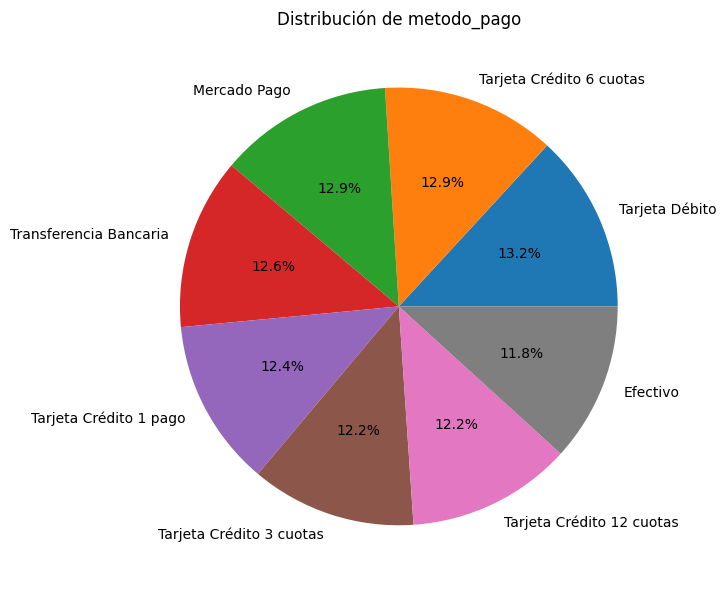

In [49]:
from IPython.display import Image, display

display(Image(filename='grafico_analytics.png'))

In [59]:
chat_interactivo()


💬 CHAT INTERACTIVO CON MEMORIA
Comandos especiales:
  - 'salir' o 'exit': terminar
  - 'limpiar' o 'clear': borrar historial
  - 'memoria': ver historial actual

🧹 Memoria limpiada
👤 Tú: Hay tostadoras disponibles?


> Entering new AgentExecutor chain...
Thought: Para determinar si hay tostadoras disponibles, necesito buscar información sobre productos relacionados con la categoría de tostadoras. La herramienta adecuada para esto sería table_search, ya que puedo buscar productos por categoría.

Action: table_search
Action Input: "tostadoras disponibles"
🤖 Buscando en tabla: inventario_sucursales
🤖 Código generado: df[(df['nombre_producto'].str.contains('tostadora', case=False, na=False)) & (df['stock_sucursal'] > 0)]
📊 Resultados de inventario_sucursales:

id_inventario            sucursal id_producto nombre_producto categoria      marca  stock_sucursal  stock_minimo  stock_maximo  precio_sucursal ultima_reposicion  proveedor pasillo     estado
    INV000163        Buenos Aires       